In [1]:
import os
import copy
import torch
import json
import time
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
import random

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
#from mlxtend.plotting import plot_decision_regions
from gpolnel.utils.tree import Tree
from gpolnel.problems.inductive_programming import SML
#from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map, _get_tree_depth
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm, GSGP
from gpolnel.operators.initializers import grow
from gpolnel.problems.problem import Problem
from gpolnel.operators.selectors import prm_tournament
from gpolnel.operators.variators import prm_efficient_gs_mtn

#from gpolnel.operators.variators import prm_efficient_gs_mtn
#from gpolnel.operators.selectors import prm_tournament

In [2]:
# !pip uninstall scikit-learn
# !pip install scikit-learn -y

In [3]:
# Define the problem for genetic algorithm
class RegressionProblem(Problem):
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        super().__init__(sspace={}, ffunction=None, min_=True)

    def evaluate_sol(self, sol):
        # Extract hyperparameters from the solution
        num_hidden_layers = int(sol[0])
        num_neurons_per_layer = int(sol[1])
        learning_rate = sol[2]

        # Define and train the model
        model = Sequential()
        model.add(Dense(num_neurons_per_layer, activation='relu', input_shape=(self.X_train.shape[1],)))
        for _ in range(num_hidden_layers):
            model.add(Dense(num_neurons_per_layer, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
        model.fit(self.X_train, self.y_train, epochs=50, batch_size=32, verbose=0)

        # Evaluate the model
        y_pred = model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, y_pred)

        # Since genetic algorithms aim to minimize the fitness function,
        # we return the negative of the mean squared error to maximize performance
        return -mse

In [4]:
data = pd.read_csv("data_project_nel.csv")
y_fat = pd.read_csv("y_fat.csv")
y_lactose = pd.read_csv("y_lactose.csv")
y_protein = pd.read_csv("y_protein.csv")

In [5]:
data.head()
# target variables are "fat_percent", "lactose_percent", "protein_percent"

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2


In [6]:
data.shape

(324, 14)

In [7]:
y_fat.head()

,fat_percent
0,3.787156
1,3.645519
2,3.458251
3,3.407140
4,4.902554


In [8]:
y_fat.shape

(324, 1)

In [9]:
y_lactose.head()

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402


In [10]:
y_lactose.shape

(324, 1)

In [11]:
y_protein.head()

,protein_percent
0,3.511685
1,3.470806
2,3.370124
3,3.221164
4,3.395152


In [12]:
y_protein.shape

(324, 1)

In [13]:
data = pd.concat([data, y_lactose, y_fat, y_protein], axis=1)

In [14]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0,4.953503,3.787156,3.511685
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0,4.983128,3.645519,3.470806
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8,4.889104,3.458251,3.370124
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2,4.868969,3.407140,3.221164
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2,4.845402,4.902554,3.395152


In [15]:
data.isnull().sum()

lactation                     0
delivery_age_years            0
dim                           0
dry_days                    147
forage_kg_day                 0
rumination_min_day            0
milk_kg_day                   0
milk_kg_min_robot             0
milkings_day                  0
errors_by_100_milkings        0
high_cdt_by_100_milkings      0
watery_by_100_milkings        0
refusals_by_milking           0
colostrum_separated_kg        0
lactose_percent               0
fat_percent                   0
protein_percent               0
dtype: int64

In [16]:
data.drop('dry_days', axis=1, inplace=True)

In [17]:
data.describe()
# check with the dictionary to see if values make sense (especially min and max)
# "milk_kg_min_robot" -> don't really understand what this means

# but the values seem to make sense, not a lot of pre processing going on

,lactation,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,2.055556,3.040895,327.617284,4.657507,527.641508,39.585367,2.806910,2.969289,1.746837,0.202839,0.067426,0.257540,11.773148,4.892862,3.725701,3.332415
std,1.320240,1.432558,46.261491,0.585053,53.863379,6.698681,0.839749,0.552387,3.505659,1.045158,0.381647,0.248818,15.401783,0.064497,0.553990,0.149771
min,1.000000,1.666667,249.000000,2.887079,316.874074,15.355600,0.951521,2.016340,0.000000,0.000000,0.000000,0.003241,0.000000,4.707464,2.360311,2.691201
25%,1.000000,1.916667,296.000000,4.318435,490.580690,34.709342,2.147157,2.529756,0.152436,0.000000,0.000000,0.084442,0.000000,4.847754,3.358378,3.246586
50%,2.000000,2.750000,313.500000,4.672403,537.830980,39.510841,2.787723,2.940860,0.786993,0.000000,0.000000,0.187785,5.800000,4.890983,3.681142,3.347080
75%,3.000000,3.750000,346.250000,5.012795,566.156378,43.973411,3.344835,3.391920,1.582636,0.000000,0.000000,0.346494,20.200000,4.932776,4.088429,3.430267
max,8.000000,9.083333,590.000000,6.340225,638.546053,59.722312,5.526386,5.024390,36.382323,13.333333,3.826955,1.520631,82.500000,5.058967,5.183688,3.682320


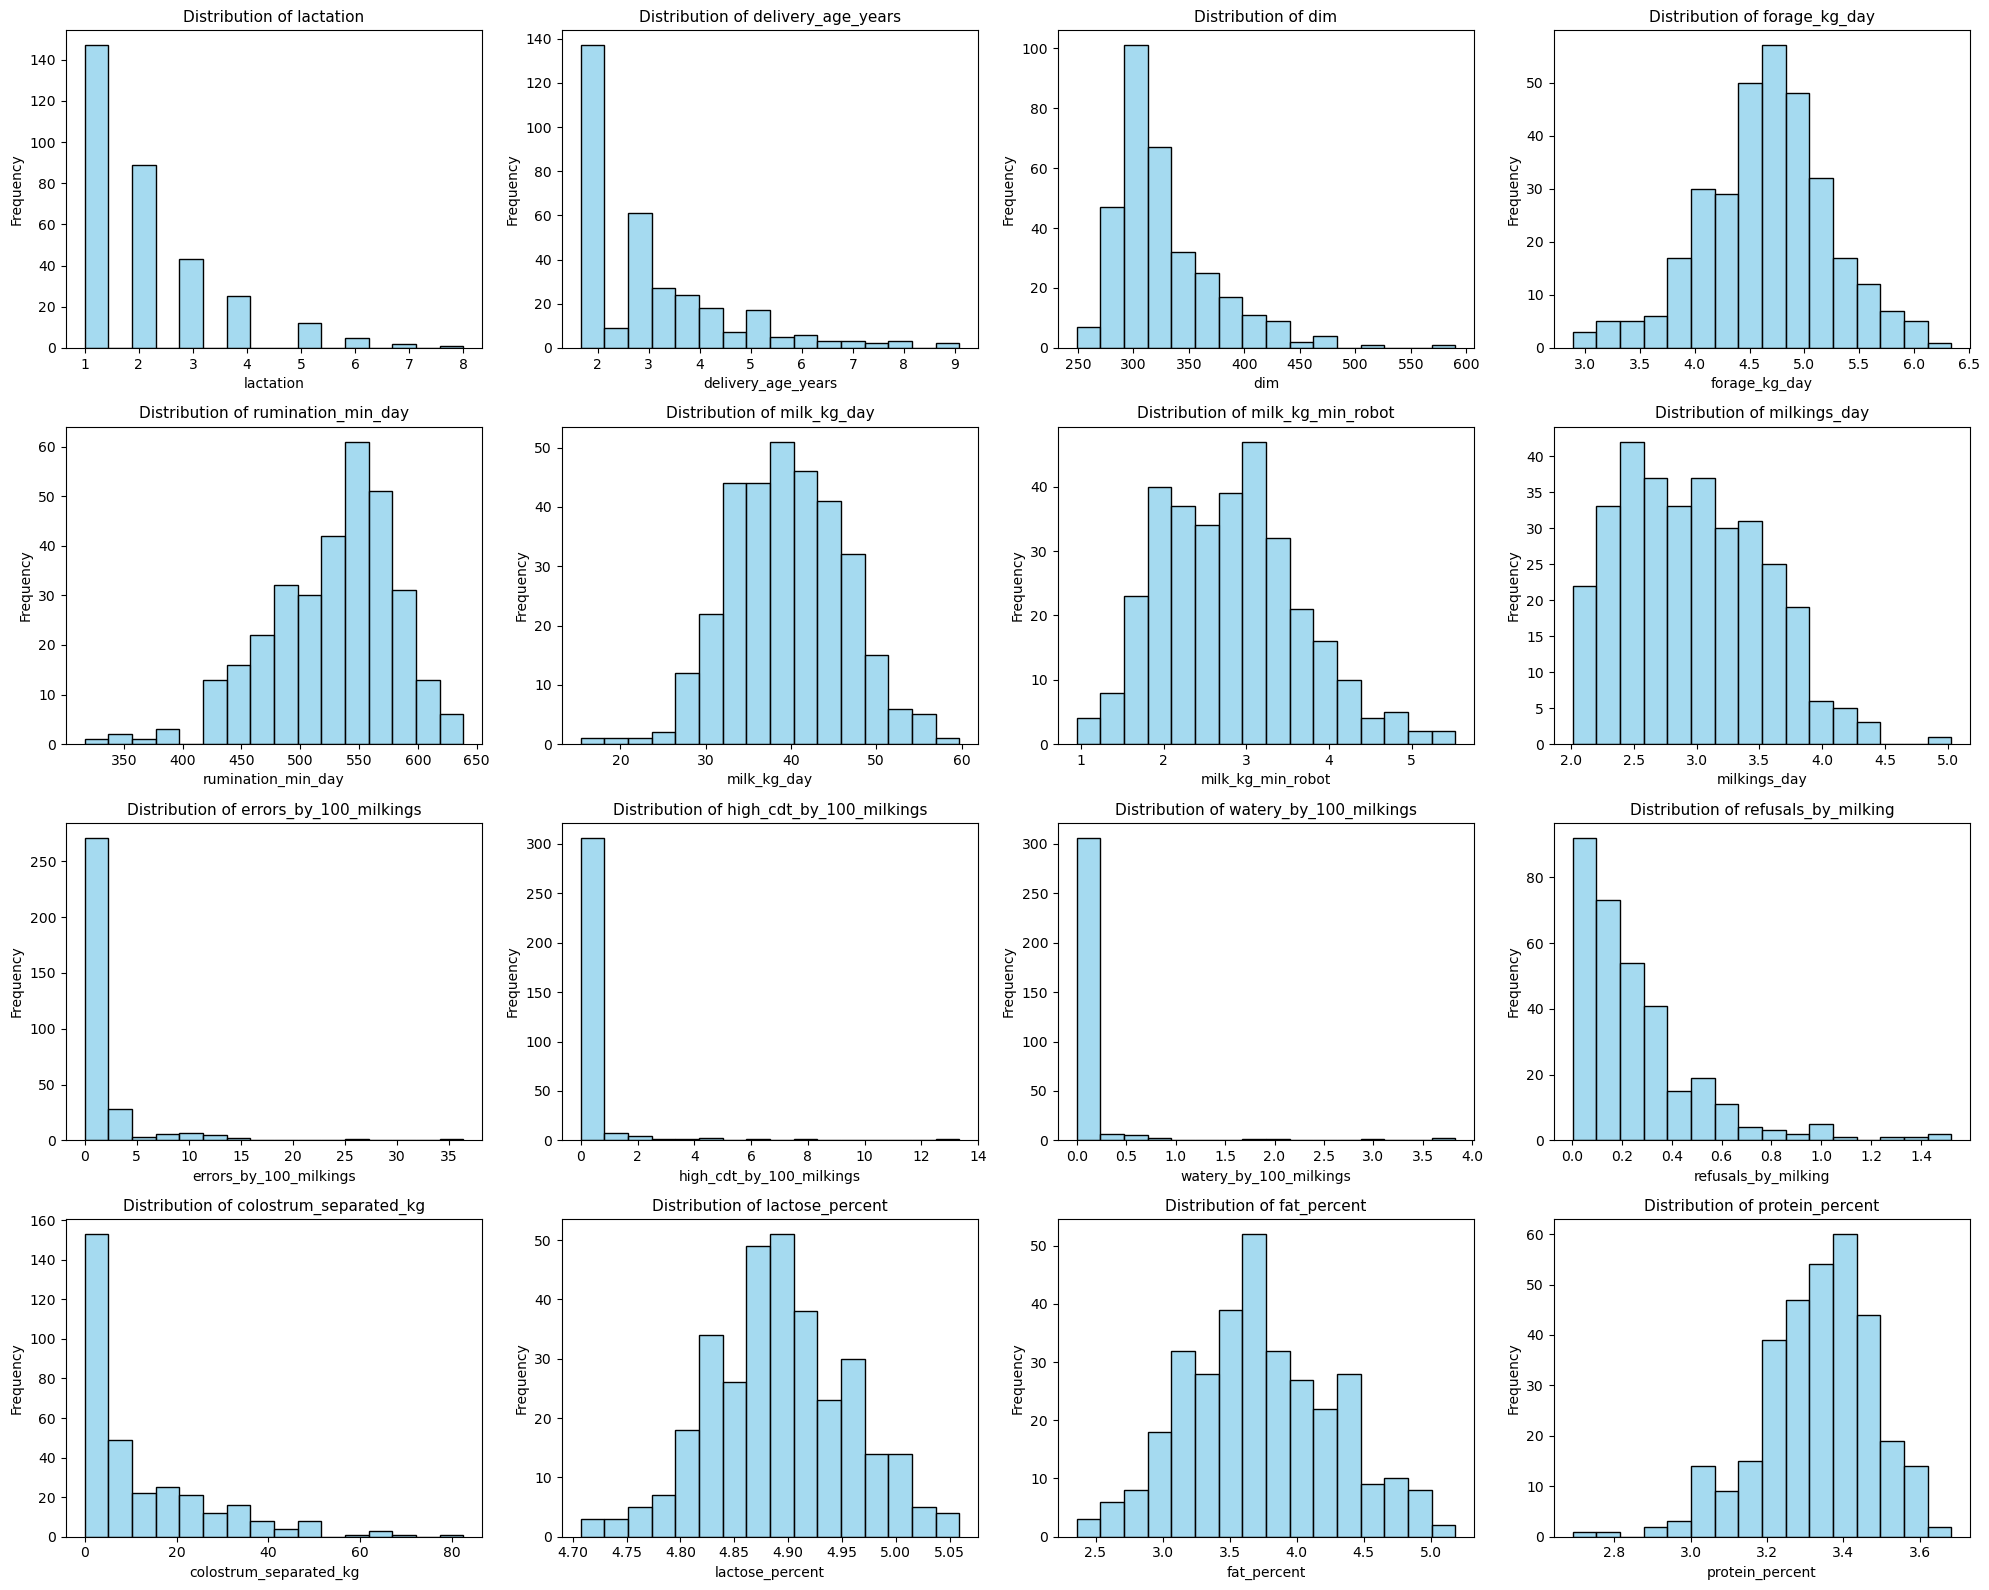

In [18]:

# Number of columns in your dataset
num_columns = len(data.columns)

# Number of rows and columns for subplots
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [19]:
# scaler = MinMaxScaler()
# data_norm = scaler.fit_transform(data)
# data_norm = pd.DataFrame(data_norm, columns=data.columns)

In [20]:
# data_norm.head()

In [21]:
X = data.drop(columns=["fat_percent", "lactose_percent", "protein_percent"])
y_fat = data["fat_percent"]
y_lactose = data["lactose_percent"]
y_protein = data["protein_percent"]

In [22]:
X_train, X_val, y_fat_train, y_fat_val = train_test_split(X, y_fat, test_size=0.2, random_state=42)
X_train, X_val, y_lactose_train, y_lactose_val = train_test_split(X, y_lactose, test_size=0.2, random_state=42)
X_train, X_val, y_protein_train, y_protein_val = train_test_split(X, y_protein, test_size=0.2, random_state=42)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [24]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_fat_train = torch.tensor(y_fat_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_fat_val = torch.tensor(y_fat_val.to_numpy(), dtype=torch.float32).view(-1, 1)
y_lactose_train = torch.tensor(y_lactose_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_lactose_val = torch.tensor(y_lactose_val.to_numpy(), dtype=torch.float32).view(-1, 1)
y_protein_train = torch.tensor(y_protein_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_protein_val= torch.tensor(y_protein_val.to_numpy(), dtype=torch.float32).view(-1, 1)

In [25]:
def dataloaders(y_train, y_val):
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)

    batch_size_GD = X_train.shape[0]
    batch_size_SGD = 1
    batch_size_MiniSGD = 32
    batch_size_ASGD = 64
    batch_size_RMSprop = 128

    train_dl_GD = DataLoader(train_ds, batch_size_GD, shuffle=True)
    val_dl_GD = DataLoader(val_ds, batch_size_GD, shuffle=True)
    train_dl_SGD = DataLoader(train_ds, batch_size_SGD, shuffle=True)
    val_dl_SGD = DataLoader(val_ds, batch_size_SGD, shuffle=True)
    train_dl_MiniSGD = DataLoader(train_ds, batch_size_MiniSGD, shuffle=True)
    val_dl_MiniSGD = DataLoader(val_ds, batch_size_MiniSGD, shuffle=True)
    train_dl_ASGD = DataLoader(train_ds, batch_size_ASGD, shuffle=True)
    val_dl_ASGD = DataLoader(val_ds, batch_size_ASGD, shuffle=True)
    train_dl_RMSprop = DataLoader(train_ds, batch_size_RMSprop, shuffle=True)
    val_dl_RMSprop = DataLoader(val_ds, batch_size_RMSprop, shuffle=True)
    

    return train_dl_GD, val_dl_GD, train_dl_SGD, val_dl_SGD, train_dl_MiniSGD, val_dl_MiniSGD, train_dl_ASGD, val_dl_ASGD, train_dl_RMSprop, val_dl_RMSprop

In [26]:
fat_data = dataloaders(y_fat_train, y_fat_val)
lactose_data = dataloaders(y_lactose_train, y_lactose_val)
protein_data = dataloaders(y_protein_train, y_protein_val)

In [27]:
def compute_rmse(predictions, targets):
    predictions = torch.tensor(predictions)
    targets = torch.tensor(targets)
    print('RMSE = ' ,torch.sqrt(torch.mean((predictions - targets) ** 2)))
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

In [28]:
# Define the Net class
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def train_model(self, num_epochs, loss_fn, optimizer, train_dl, train_size, batch_size, x_valid, y_valid):
        self.apply(self._init_weights)
        loss_hist_train = [0] * num_epochs
        rmse_hist_train = [0] * num_epochs
        loss_hist_valid = [0] * num_epochs
        rmse_hist_valid = [0] * num_epochs
        
        for epoch in tqdm(range(num_epochs)):
            epoch_train_loss = 0
            train_predictions = []
            train_targets = []
            self.train()
            for x_batch, y_batch in train_dl:
                pred = self(x_batch)
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                epoch_train_loss += loss.item()
                train_predictions.append(pred.detach().cpu().numpy())
                train_targets.append(y_batch.detach().cpu().numpy())
            
            train_predictions = np.concatenate(train_predictions)
            train_targets = np.concatenate(train_targets)
            loss_hist_train[epoch] = epoch_train_loss / (train_size / batch_size)
            rmse_hist_train[epoch] = compute_rmse(train_predictions, train_targets)
            
            self.eval()
            with torch.no_grad():
                pred = self(x_valid)
                valid_loss = loss_fn(pred, y_valid).item()
                loss_hist_valid[epoch] = valid_loss
                rmse_hist_valid[epoch] = compute_rmse(y_valid.cpu().numpy(), pred.cpu().numpy())
        return loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid

# Instantiate the neural networks for each target variable
input_dim = X_train.shape[1]
nn_names = ['GD', 'SGD', 'MiniSGD', 'ASGD', 'RMSprop']
nn_torch = {k: Net(input_dim) for k in nn_names}

# Define loss function and optimizer
loss_fn = nn.MSELoss()
learning_rate =.05
optimizer = {
    'GD': torch.optim.SGD(nn_torch['GD'].parameters(), lr=learning_rate),
    'SGD': torch.optim.SGD(nn_torch['SGD'].parameters(), lr=learning_rate),
    'MiniSGD': torch.optim.SGD(nn_torch['MiniSGD'].parameters(), lr=learning_rate),
    'ASGD': torch.optim.ASGD(nn_torch['ASGD'].parameters(), lr=learning_rate),
    'RMSprop': torch.optim.RMSprop(nn_torch['RMSprop'].parameters(), lr=learning_rate)
}



In [29]:
num_epochs = 20

# Function to train and evaluate models for a given target variable
def train_and_evaluate(nn_torch, optimizer, dataloaders, y_valid):
    train_dl_GD, val_dl_GD, train_dl_SGD, val_dl_SGD, train_dl_MiniSGD, val_dl_MiniSGD, train_dl_ASGD, val_dl_ASGD, train_dl_RMSprop, val_dl_RMSprop = dataloaders
    history = {}

    history['GD'] = nn_torch['GD'].train_model(
        loss_fn=loss_fn, 
        optimizer=optimizer['GD'], 
        num_epochs=num_epochs, 
        train_dl=train_dl_GD, 
        train_size=X_train.shape[0], 
        batch_size=train_dl_GD.batch_size,
        x_valid=X_val, y_valid=y_valid
    )

    for dl in ['SGD', 'MiniSGD', 'ASGD', 'RMSprop']:
        history[dl] = nn_torch[dl].train_model(
            loss_fn=loss_fn, 
            optimizer=optimizer[dl], 
            num_epochs=num_epochs, 
            train_dl=eval(f'train_dl_{dl}'), 
            train_size=X_train.shape[0], 
            batch_size=eval(f'train_dl_{dl}.batch_size'),
            x_valid=X_val, y_valid=y_valid
        )
    return history

# Training for fat percentage
print("Training models for fat percentage...")
history_fat = train_and_evaluate(nn_torch, optimizer, fat_data, y_fat_val)

# Training for lactose percentage
print("Training models for lactose percentage...")
history_lactose = train_and_evaluate(nn_torch, optimizer, lactose_data, y_lactose_val)

# Training for protein percentage
print("Training models for protein percentage...")
history_protein = train_and_evaluate(nn_torch, optimizer, protein_data, y_protein_val)


Training models for fat percentage...


100%|██████████| 20/20 [00:00<00:00, 153.81it/s]


RMSE =  tensor(3.3233)
RMSE =  tensor(3.2249)
RMSE =  tensor(3.2485)
RMSE =  tensor(3.1622)
RMSE =  tensor(3.1879)
RMSE =  tensor(3.1019)
RMSE =  tensor(3.1295)
RMSE =  tensor(3.0412)
RMSE =  tensor(3.0706)
RMSE =  tensor(2.9844)
RMSE =  tensor(3.0148)
RMSE =  tensor(2.9359)
RMSE =  tensor(2.9665)
RMSE =  tensor(2.8969)
RMSE =  tensor(2.9271)
RMSE =  tensor(2.8669)
RMSE =  tensor(2.8966)
RMSE =  tensor(2.8444)
RMSE =  tensor(2.8736)
RMSE =  tensor(2.8276)
RMSE =  tensor(2.8564)
RMSE =  tensor(2.8151)
RMSE =  tensor(2.8436)
RMSE =  tensor(2.8056)
RMSE =  tensor(2.8339)
RMSE =  tensor(2.7983)
RMSE =  tensor(2.8264)
RMSE =  tensor(2.7925)
RMSE =  tensor(2.8206)
RMSE =  tensor(2.7880)
RMSE =  tensor(2.8161)
RMSE =  tensor(2.7843)
RMSE =  tensor(2.8124)
RMSE =  tensor(2.7814)
RMSE =  tensor(2.8094)
RMSE =  tensor(2.7789)
RMSE =  tensor(2.8069)
RMSE =  tensor(2.7768)
RMSE =  tensor(2.8049)
RMSE =  tensor(2.7751)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(2.7964)
RMSE =  tensor(2.7588)
RMSE =  tensor(2.7871)
RMSE =  tensor(2.7587)


 15%|█▌        | 3/20 [00:00<00:00, 22.96it/s]

RMSE =  tensor(2.7870)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7870)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)


 30%|███       | 6/20 [00:00<00:00, 23.79it/s]

RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)


 45%|████▌     | 9/20 [00:00<00:00, 23.75it/s]

RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)


 60%|██████    | 12/20 [00:00<00:00, 24.25it/s]

RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)


 75%|███████▌  | 15/20 [00:00<00:00, 24.58it/s]

RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  

100%|██████████| 20/20 [00:00<00:00, 24.39it/s]


tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)


100%|██████████| 20/20 [00:00<00:00, 438.18it/s]


RMSE =  tensor(3.0185)
RMSE =  tensor(2.7881)
RMSE =  tensor(2.8075)
RMSE =  tensor(2.7676)
RMSE =  tensor(2.7951)
RMSE =  tensor(2.7632)
RMSE =  tensor(2.7915)
RMSE =  tensor(2.7616)
RMSE =  tensor(2.7900)
RMSE =  tensor(2.7608)
RMSE =  tensor(2.7893)
RMSE =  tensor(2.7603)
RMSE =  tensor(2.7888)
RMSE =  tensor(2.7600)
RMSE =  tensor(2.7884)
RMSE =  tensor(2.7598)
RMSE =  tensor(2.7882)
RMSE =  tensor(2.7596)
RMSE =  tensor(2.7880)
RMSE =  tensor(2.7595)
RMSE =  tensor(2.7879)
RMSE =  tensor(2.7594)
RMSE =  tensor(2.7877)
RMSE =  tensor(2.7593)
RMSE =  tensor(2.7877)
RMSE =  tensor(2.7592)
RMSE =  tensor(2.7876)
RMSE =  tensor(2.7592)
RMSE =  tensor(2.7875)
RMSE =  tensor(2.7591)
RMSE =  tensor(2.7875)
RMSE =  tensor(2.7591)
RMSE =  tensor(2.7874)
RMSE =  tensor(2.7591)
RMSE =  tensor(2.7874)
RMSE =  tensor(2.7590)
RMSE =  tensor(2.7874)
RMSE =  tensor(2.7590)
RMSE =  tensor(2.7873)
RMSE =  tensor(2.7590)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(3.0345)
RMSE =  tensor(2.8141)
RMSE =  tensor(2.8295)
RMSE =  tensor(2.7763)
RMSE =  tensor(2.8028)
RMSE =  tensor(2.7687)
RMSE =  tensor(2.7965)
RMSE =  tensor(2.7655)
RMSE =  tensor(2.7937)
RMSE =  tensor(2.7632)
RMSE =  tensor(2.7916)
RMSE =  tensor(2.7622)
RMSE =  tensor(2.7906)
RMSE =  tensor(2.7615)
RMSE =  tensor(2.7899)
RMSE =  tensor(2.7611)
RMSE =  tensor(2.7895)
RMSE =  tensor(2.7608)
RMSE =  tensor(2.7892)
RMSE =  tensor(2.7605)
RMSE =  tensor(2.7889)
RMSE =  tensor(2.7602)
RMSE =  tensor(2.7886)
RMSE =  tensor(2.7601)
RMSE =  tensor(2.7884)
RMSE =  tensor(2.7599)
RMSE =  tensor(2.7883)
RMSE =  tensor(2.7598)


100%|██████████| 20/20 [00:00<00:00, 433.79it/s]


RMSE =  tensor(2.7882)
RMSE =  tensor(2.7597)
RMSE =  tensor(2.7881)
RMSE =  tensor(2.7596)
RMSE =  tensor(2.7880)
RMSE =  tensor(2.7596)
RMSE =  tensor(2.7879)
RMSE =  tensor(2.7595)
RMSE =  tensor(2.7879)
RMSE =  tensor(2.7595)
RMSE =  tensor(2.7878)
RMSE =  tensor(2.7594)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(3.0665)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)


100%|██████████| 20/20 [00:00<00:00, 625.24it/s]


RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
RMSE =  tensor(2.7869)
RMSE =  tensor(2.7587)
Training models for lactose percentage...


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(4.4278)
RMSE =  tensor(4.3100)
RMSE =  tensor(4.3268)
RMSE =  tensor(4.2134)
RMSE =  tensor(4.2302)
RMSE =  tensor(4.1156)
RMSE =  tensor(4.1343)
RMSE =  tensor(4.0348)
RMSE =  tensor(4.0545)
RMSE =  tensor(3.9796)
RMSE =  tensor(3.9995)
RMSE =  tensor(3.9466)
RMSE =  tensor(3.9659)
RMSE =  tensor(3.9271)
RMSE =  tensor(3.9457)
RMSE =  tensor(3.9153)


 50%|█████     | 10/20 [00:00<00:00, 91.07it/s]

RMSE =  tensor(3.9332)
RMSE =  tensor(3.9076)
RMSE =  tensor(3.9249)
RMSE =  tensor(3.9025)
RMSE =  tensor(3.9192)
RMSE =  tensor(3.8988)
RMSE =  tensor(3.9152)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.9122)
RMSE =  tensor(3.8941)
RMSE =  tensor(3.9099)
RMSE =  tensor(3.8925)


100%|██████████| 20/20 [00:00<00:00, 83.93it/s]


RMSE =  tensor(3.9081)
RMSE =  tensor(3.8912)
RMSE =  tensor(3.9067)
RMSE =  tensor(3.8902)
RMSE =  tensor(3.9055)
RMSE =  tensor(3.8894)
RMSE =  tensor(3.9045)
RMSE =  tensor(3.8887)
RMSE =  tensor(3.9037)
RMSE =  tensor(3.8881)
RMSE =  tensor(3.9031)
RMSE =  tensor(3.8876)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(3.9076)
RMSE =  tensor(3.8827)
RMSE =  tensor(3.8962)
RMSE =  tensor(3.8826)


 15%|█▌        | 3/20 [00:00<00:00, 23.96it/s]

RMSE =  tensor(3.8962)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)


 30%|███       | 6/20 [00:00<00:00, 23.85it/s]

RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)


 45%|████▌     | 9/20 [00:00<00:00, 23.61it/s]

RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)


 60%|██████    | 12/20 [00:00<00:00, 23.39it/s]

RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)


 75%|███████▌  | 15/20 [00:00<00:00, 23.23it/s]

RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)


 90%|█████████ | 18/20 [00:00<00:00, 23.07it/s]

RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)


100%|██████████| 20/20 [00:00<00:00, 23.27it/s]


RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(4.0500)
RMSE =  tensor(3.8957)
RMSE =  tensor(3.9065)
RMSE =  tensor(3.8871)
RMSE =  tensor(3.9006)
RMSE =  tensor(3.8850)
RMSE =  tensor(3.8988)
RMSE =  tensor(3.8842)
RMSE =  tensor(3.8980)
RMSE =  tensor(3.8837)
RMSE =  tensor(3.8975)
RMSE =  tensor(3.8834)
RMSE =  tensor(3.8972)
RMSE =  tensor(3.8833)
RMSE =  tensor(3.8970)
RMSE =  tensor(3.8831)
RMSE =  tensor(3.8969)
RMSE =  tensor(3.8831)


100%|██████████| 20/20 [00:00<00:00, 400.77it/s]


RMSE =  tensor(3.8968)
RMSE =  tensor(3.8830)
RMSE =  tensor(3.8967)
RMSE =  tensor(3.8830)
RMSE =  tensor(3.8966)
RMSE =  tensor(3.8829)
RMSE =  tensor(3.8966)
RMSE =  tensor(3.8829)
RMSE =  tensor(3.8965)
RMSE =  tensor(3.8828)
RMSE =  tensor(3.8965)
RMSE =  tensor(3.8828)
RMSE =  tensor(3.8965)
RMSE =  tensor(3.8828)
RMSE =  tensor(3.8964)
RMSE =  tensor(3.8828)
RMSE =  tensor(3.8964)
RMSE =  tensor(3.8828)
RMSE =  tensor(3.8964)
RMSE =  tensor(3.8828)
RMSE =  tensor(3.8964)
RMSE =  tensor(3.8827)


100%|██████████| 20/20 [00:00<00:00, 454.15it/s]


RMSE =  tensor(4.3110)
RMSE =  tensor(3.9842)
RMSE =  tensor(3.9697)
RMSE =  tensor(3.9054)
RMSE =  tensor(3.9180)
RMSE =  tensor(3.8916)
RMSE =  tensor(3.9060)
RMSE =  tensor(3.8876)
RMSE =  tensor(3.9019)
RMSE =  tensor(3.8862)
RMSE =  tensor(3.9004)
RMSE =  tensor(3.8852)
RMSE =  tensor(3.8993)
RMSE =  tensor(3.8847)
RMSE =  tensor(3.8987)
RMSE =  tensor(3.8842)
RMSE =  tensor(3.8981)
RMSE =  tensor(3.8839)
RMSE =  tensor(3.8978)
RMSE =  tensor(3.8837)
RMSE =  tensor(3.8976)
RMSE =  tensor(3.8836)
RMSE =  tensor(3.8974)
RMSE =  tensor(3.8835)
RMSE =  tensor(3.8973)
RMSE =  tensor(3.8834)
RMSE =  tensor(3.8972)
RMSE =  tensor(3.8833)
RMSE =  tensor(3.8971)
RMSE =  tensor(3.8833)
RMSE =  tensor(3.8970)
RMSE =  tensor(3.8832)
RMSE =  tensor(3.8969)
RMSE =  tensor(3.8832)
RMSE =  tensor(3.8969)
RMSE =  tensor(3.8831)
RMSE =  tensor(3.8968)
RMSE =  tensor(3.8831)
RMSE =  tensor(3.8968)
RMSE =  tensor(3.8830)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(4.2083)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  

100%|██████████| 20/20 [00:00<00:00, 615.10it/s]


tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
RMSE =  tensor(3.8961)
RMSE =  tensor(3.8826)
Training models for protein percentage...


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(2.9352)
RMSE =  tensor(2.8594)
RMSE =  tensor(2.8804)
RMSE =  tensor(2.8104)
RMSE =  tensor(2.8335)
RMSE =  tensor(2.7677)
RMSE =  tensor(2.7921)
RMSE =  tensor(2.7279)
RMSE =  tensor(2.7527)
RMSE =  tensor(2.6884)
RMSE =  tensor(2.7135)
RMSE =  tensor(2.6482)
RMSE =  tensor(2.6734)
RMSE =  tensor(2.6072)
RMSE =  tensor(2.6323)
RMSE =  tensor(2.5643)
RMSE =  tensor(2.5902)
RMSE =  tensor(2.5206)
RMSE =  tensor(2.5481)
RMSE =  tensor(2.4804)
RMSE =  tensor(2.5094)
RMSE =  tensor(2.4461)
RMSE =  tensor(2.4764)
RMSE =  tensor(2.4192)


100%|██████████| 20/20 [00:00<00:00, 507.54it/s]


RMSE =  tensor(2.4500)
RMSE =  tensor(2.3986)
RMSE =  tensor(2.4296)
RMSE =  tensor(2.3830)
RMSE =  tensor(2.4140)
RMSE =  tensor(2.3710)
RMSE =  tensor(2.4020)
RMSE =  tensor(2.3618)
RMSE =  tensor(2.3927)
RMSE =  tensor(2.3547)
RMSE =  tensor(2.3854)
RMSE =  tensor(2.3490)
RMSE =  tensor(2.3797)
RMSE =  tensor(2.3444)
RMSE =  tensor(2.3750)
RMSE =  tensor(2.3407)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(2.3522)
RMSE =  tensor(2.3137)
RMSE =  tensor(2.3433)
RMSE =  tensor(2.3136)


 15%|█▌        | 3/20 [00:00<00:00, 23.14it/s]

RMSE =  tensor(2.3432)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3432)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3432)
RMSE =  tensor(2.3135)


 30%|███       | 6/20 [00:00<00:00, 23.21it/s]

RMSE =  tensor(2.3432)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3432)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3432)
RMSE =  tensor(2.3135)


 45%|████▌     | 9/20 [00:00<00:00, 23.99it/s]

RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)


 60%|██████    | 12/20 [00:00<00:00, 24.82it/s]

RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)


 75%|███████▌  | 15/20 [00:00<00:00, 25.25it/s]

RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)


 90%|█████████ | 18/20 [00:00<00:00, 25.58it/s]

RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)


100%|██████████| 20/20 [00:00<00:00, 25.03it/s]


RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  tensor(2.6295)
RMSE =  tensor(2.3602)
RMSE =  tensor(2.3743)
RMSE =  tensor(2.3268)
RMSE =  tensor(2.3546)
RMSE =  tensor(2.3202)


100%|██████████| 20/20 [00:00<00:00, 459.56it/s]


RMSE =  tensor(2.3496)
RMSE =  tensor(2.3177)
RMSE =  tensor(2.3475)
RMSE =  tensor(2.3165)
RMSE =  tensor(2.3463)
RMSE =  tensor(2.3156)
RMSE =  tensor(2.3455)
RMSE =  tensor(2.3152)
RMSE =  tensor(2.3451)
RMSE =  tensor(2.3149)
RMSE =  tensor(2.3448)
RMSE =  tensor(2.3147)
RMSE =  tensor(2.3445)
RMSE =  tensor(2.3145)
RMSE =  tensor(2.3443)
RMSE =  tensor(2.3144)
RMSE =  tensor(2.3442)
RMSE =  tensor(2.3143)
RMSE =  tensor(2.3441)
RMSE =  tensor(2.3142)
RMSE =  tensor(2.3440)
RMSE =  tensor(2.3141)
RMSE =  tensor(2.3439)
RMSE =  tensor(2.3141)
RMSE =  tensor(2.3439)
RMSE =  tensor(2.3140)
RMSE =  tensor(2.3438)
RMSE =  tensor(2.3140)
RMSE =  tensor(2.3437)
RMSE =  tensor(2.3139)
RMSE =  tensor(2.3437)
RMSE =  tensor(2.3139)
RMSE =  tensor(2.3437)
RMSE =  tensor(2.3139)


  0%|          | 0/20 [00:00<?, ?it/s]

RMSE =  

100%|██████████| 20/20 [00:00<00:00, 497.91it/s]


tensor(2.6903)
RMSE =  tensor(2.4352)
RMSE =  tensor(2.4328)
RMSE =  tensor(2.3502)
RMSE =  tensor(2.3760)
RMSE =  tensor(2.3290)
RMSE =  tensor(2.3590)
RMSE =  tensor(2.3227)
RMSE =  tensor(2.3533)
RMSE =  tensor(2.3200)
RMSE =  tensor(2.3506)
RMSE =  tensor(2.3183)
RMSE =  tensor(2.3488)
RMSE =  tensor(2.3173)
RMSE =  tensor(2.3477)
RMSE =  tensor(2.3166)
RMSE =  tensor(2.3469)
RMSE =  tensor(2.3160)
RMSE =  tensor(2.3462)
RMSE =  tensor(2.3156)
RMSE =  tensor(2.3458)
RMSE =  tensor(2.3153)
RMSE =  tensor(2.3454)
RMSE =  tensor(2.3151)
RMSE =  tensor(2.3452)
RMSE =  tensor(2.3149)
RMSE =  tensor(2.3450)
RMSE =  tensor(2.3148)
RMSE =  tensor(2.3448)
RMSE =  tensor(2.3147)
RMSE =  tensor(2.3447)
RMSE =  tensor(2.3146)
RMSE =  tensor(2.3446)
RMSE =  tensor(2.3145)
RMSE =  tensor(2.3445)
RMSE =  tensor(2.3144)
RMSE =  tensor(2.3444)
RMSE =  tensor(2.3143)
RMSE =  tensor(2.3443)
RMSE =  tensor(2.3143)


100%|██████████| 20/20 [00:00<00:00, 713.01it/s]

RMSE =  tensor(2.5922)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)
RMSE =  tensor(2.3431)
RMSE =  tensor(2.3135)


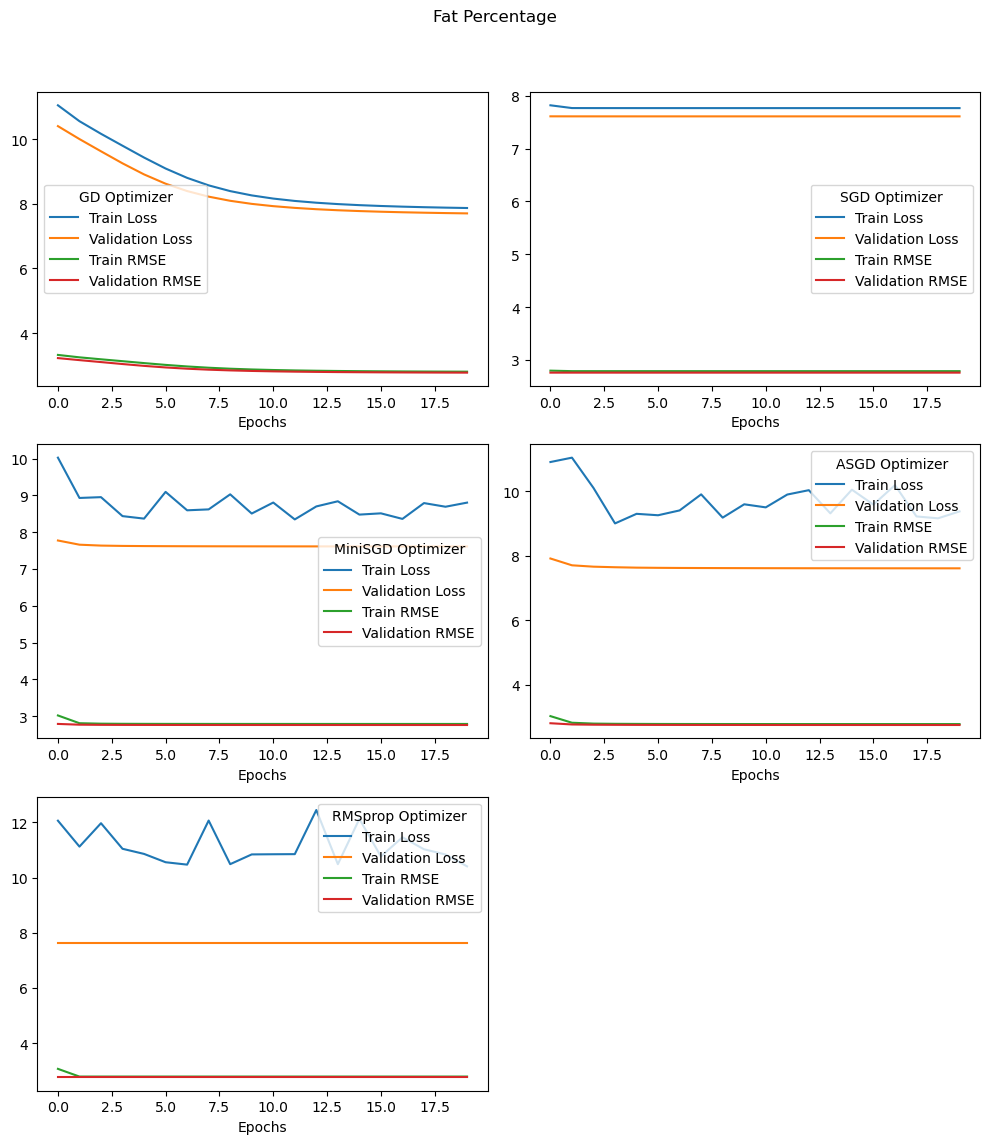

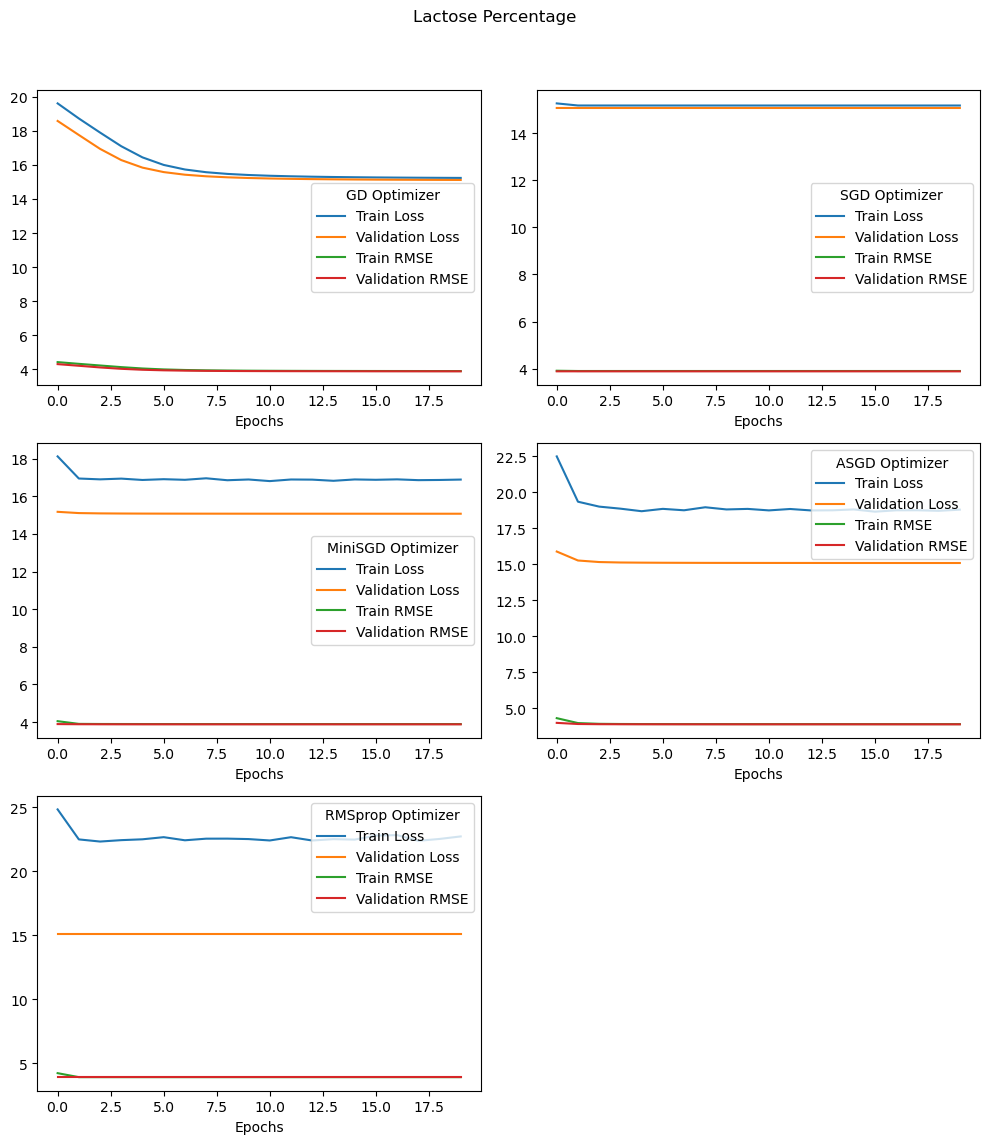

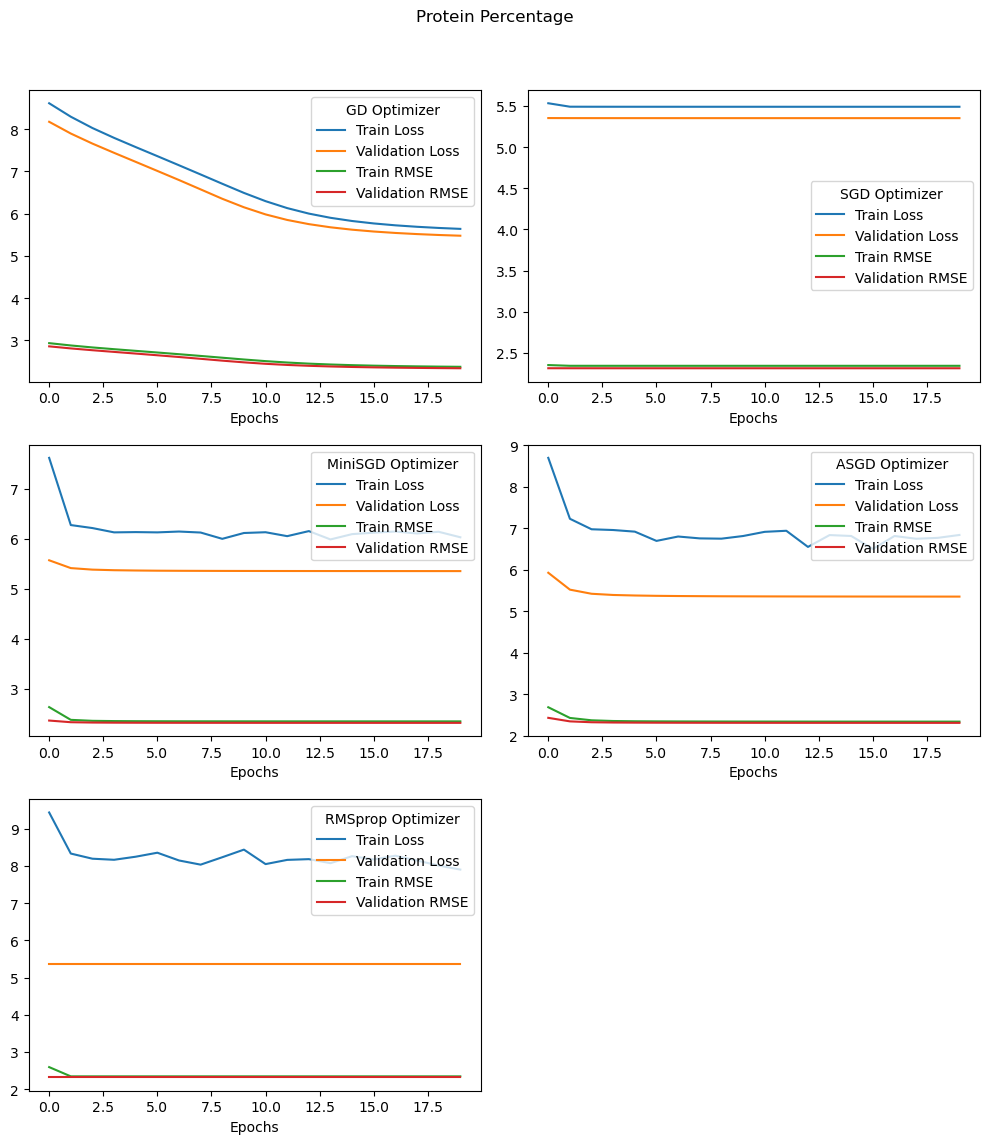

In [30]:
def plot_results(history, title):
    plt.figure(figsize=(10, 12))
    num_plots = len(history.keys())
    rows = 3
    cols = (num_plots + rows - 1) // rows
    
    for i, (nn_name, data) in enumerate(history.items(), 1):
        plt.subplot(rows, cols, i)
        plt.plot(data[0], label='Train Loss')
        plt.plot(data[1], label='Validation Loss')
        plt.plot(data[2], label='Train RMSE')
        plt.plot(data[3], label='Validation RMSE')
        plt.xlabel('Epochs')
        plt.legend(title=nn_name + ' Optimizer')
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
    plt.show()

# Plot results for each target variable
plot_results(history_fat, "Fat Percentage")
plot_results(history_lactose, "Lactose Percentage")
plot_results(history_protein, "Protein Percentage")

In [32]:
def decision_tree(history_tf, title, nn_tf):
    plt.figure(figsize=(12, 2))
    for nn_i, nn_name in enumerate(nn_tf.keys()):
        plt.subplot(1, len(history_tf), nn_i+1)
        plot_decision_regions(X=X_val.cpu().numpy(), 
                      y=y_val.cpu().int().numpy(),
                      clf=nn_tf[nn_name])
        plt.xlabel(r'$x_1$', size=8)
        plt.ylabel(r'$x_2$', size=8)
        plt.title(nn_name+' Tensorflow NN\nDecision Regions', size=8)
    plt.show()


decision_tree(history_fat, "Fat Percentage", nn_torch)
decision_tree(history_lactose, "Lactose Percentage", nn_torch)
decision_tree(history_protein, "Protein Percentage", nn_torch)
